In [1]:
import lin_reg_algos
import lin_reg_interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
sqrtm([[4,0],[0,4]])

array([[2., 0.],
       [0., 2.]])

In [3]:
from numpy.linalg import inv
from numpy.linalg import matrix_power

Algorithm:

1. Generate $X \sim \mathcal{N}(0, \Sigma)$
2. Estimate $\hat{\Sigma}$
3. Rescale X by $\hat{\Sigma}^{-\frac{1}{2}} \rightarrow \tilde{X}$
4. Run CoinPress on $\tilde{X}, y \rightarrow \tilde{\beta}$ 
5. Resclae $\tilde{\beta}$ by $\hat{\Sigma}^{-\frac{1}{2}} \rightarrow \hat{\beta}$

In [4]:
def generate_data_nonidentity_cov(n, d, underlying_dist, sigma):
    # sigma must be a dxd covariance matrix
    assert(len(sigma) == d)
    assert(len(sigma[0]) == d)
    
    X = np.random.multivariate_normal(np.zeros(d), sigma, n)
    X = np.array(X)

    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + np.random.normal(0, 1))
    y = np.array(y)

    return X, y

In [7]:
data = generate_data_nonidentity_cov(10,2,lin_reg_interactive.generate_normal_underlying_dist(2,0,1),np.array([[10,0],[0,1]]))

In [62]:
def losses(n_values, d, iters, total_privacy_budget, loss_func, beta_mean=0, beta_var=1.0):
    
    priv_algo_losses = []
    nonpriv_algo_losses = []
    priv_losses = []
    nonpriv_losses = []
    
    for n in n_values:
        priv_algo_losses_for_n = []
        nonpriv_algo_losses_for_n = []
        priv_losses_for_n = []
        nonpriv_losses_for_n = []
            
        for i in range(iters):
            c = [0] * d
            r = 100 * np.sqrt(d)

            underlying_dist = lin_reg_interactive.generate_normal_underlying_dist(d, beta_mean, beta_var)
            sigma = np.eye(d) * 10
#             sigma[0][0] = 6
#             sigma[0][1] = 2
#             sigma[1][0] = 2
            
            x, y = generate_data_nonidentity_cov(n, d, underlying_dist, sigma)

            """ 2. Estimate Sigma Hat"""
            sigma_hat = lin_reg_algos.coinpress_linreg_covariance(x, d, total_budget = 2 * total_privacy_budget / 3)
#             print(sigma_hat)
#             print(sigma)

            """ 3. Rescale X by Sigma Hat"""
            uniform_norm_x = x @ inv(sqrtm(sigma_hat))
            nonpriv_uniform_norm_x = x @ inv(sqrtm(sigma))
            
            """ 4. Find Beta Tilde"""
            priv_beta_tilde = lin_reg_algos.coinpress_linreg(uniform_norm_x, y, underlying_dist, c, r, total_privacy_budget / 3)
            nonpriv_beta_tilde = lin_reg_interactive.linreg_closed_form_solution(nonpriv_uniform_norm_x, y)
            
            """ 5. Rescale Beta Tilde by Sigma Hat"""
            priv_algo_beta_hat = inv(sqrtm(sigma_hat)) @ priv_beta_tilde
            priv_algo_losses_for_n.append(loss_func(priv_algo_beta_hat, underlying_dist[0], d))
            
            nonpriv_algo_beta_hat = inv(sqrtm(sigma)) @ nonpriv_beta_tilde
            nonpriv_algo_losses_for_n.append(loss_func(nonpriv_algo_beta_hat, underlying_dist[0], d))
            
            priv_beta_hat = lin_reg_algos.coinpress_linreg(x, y, underlying_dist, c, r, total_privacy_budget)
            priv_losses_for_n.append(loss_func(priv_beta_hat, underlying_dist[0], d))
            
            nonpriv_beta_hat = lin_reg_interactive.linreg_closed_form_solution(x, y)
            nonpriv_losses_for_n.append(loss_func(nonpriv_beta_hat, underlying_dist[0], d))
             
            
        """ finds the mean loss for the current n for each of the following scenarios """
        
        nonpriv_algo_losses_for_n = np.array(nonpriv_algo_losses_for_n)
        nonpriv_algo_losses.append(np.mean(nonpriv_algo_losses_for_n))
        
        priv_algo_losses_for_n = np.array(priv_algo_losses_for_n)
        priv_algo_losses.append(np.mean(priv_algo_losses_for_n))
        
        priv_losses_for_n = np.array(priv_losses_for_n)
        priv_losses.append(np.mean(priv_losses_for_n))
        
        nonpriv_losses_for_n = np.array(nonpriv_losses_for_n)
        nonpriv_losses.append(np.mean(nonpriv_losses_for_n))
        
    # TODO : add title, make y axis 0 -> 2, make sure label in top right corner / out of the way!
#     plt.plot(n_values, nonpriv_algo_losses, 'r', label='Closed-Form Solution Using Algorithm')
    plt.plot(n_values, priv_algo_losses, 'b', label='Private Solution')
    plt.plot(n_values, nonpriv_losses, 'r', label='Closed-Form Solution')
#     plt.plot(n_values, priv_losses, 'green', label='Private Solution without Extension')
    plt.legend(loc="upper right")
    axes = plt.gca()
    axes.set_ylabel('Population Loss')
    axes.set_xlabel('n')
    axes.set_title('Extended Algorithm: Non-Identity Sigma d = 5')
    axes.set_ylim([0.9,2])

    return nonpriv_algo_losses, nonpriv_losses, priv_algo_losses, priv_losses

([1.0044935793641452,
  1.0043136217852267,
  0.9964715186668801,
  0.9982987309060565,
  0.9999534939979964,
  1.0062249352566341,
  1.00925951256368,
  1.0043179857922635,
  1.0061576278233675,
  1.013963906706976],
 [0.9837794539575251,
  0.9920136930916421,
  1.0164233538146503,
  1.0079113163225364,
  1.0069918422843203,
  0.997429961731917,
  0.9943997773461599,
  1.003521205750248,
  0.998794593419907,
  0.9928550649753626],
 [1.0961449725573866,
  1.0506374919076946,
  1.0230010543418884,
  1.0213170382811299,
  1.0172389940887299,
  1.0165420515067374,
  1.0068724887379856,
  1.0109947483252373,
  1.0042652549209992,
  0.9923116414134162],
 [140.984629728642,
  116.75696480134619,
  137.8424865341938,
  162.23015254671026,
  169.36284621848054,
  132.43525222308546,
  107.55947916486625,
  147.35613246071293,
  132.0568340105479,
  139.73559528882188])

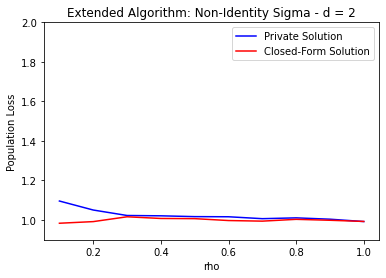

In [63]:
losses(range(1000,3001,250), 10, 50, 0.5, lin_reg_interactive.loss)

In [ ]:
[[4,0],[0,4]]
np.array([[2,0],[0,2]])@np.array([[2,0],[0,2]])